# Project 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.metrics import accuracy_score
# trying different models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


# The following line is needed to show plots inline in notebooks
%matplotlib inline 

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,Unnamed: 0,claim,claimant,date,id,label,related_articles
0,0,A line from George Orwell's novel 1984 predict...,NaN,17/07/2017,0,0,"[122094, 122580, 130685, 134765]"
1,1,Maine legislature candidate Leslie Gibson insu...,NaN,17/03/2018,1,2,"[106868, 127320, 128060]"
2,2,A 17-year-old girl named Alyssa Carson is bein...,NaN,18/07/2018,4,1,"[132130, 132132, 149722]"
3,3,In 1988 author Roald Dahl penned an open lette...,NaN,04/02/2019,5,2,"[123254, 123418, 127464]"
4,4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,22/03/2016,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]"


In [4]:
data.shape

(15555, 7)

## Data Cleaning

### Claimant

In [5]:
# There are 4962 missing values in claimant
missing_claim = data[data['claimant'].isna()]
missing_claim.shape[0]

4962

In [6]:
# Of the claimant missing, how many are false-0, partly true-1, true-2?
missing_data = data[data['claimant'].isna()]
missing_data.label.value_counts(normalize=True)
# roughly 87% of claims with missing claimants are not completely true

0    0.611447
1    0.259371
2    0.129182
Name: label, dtype: float64

In [7]:
# fill missing claimants with "unknown"
data['claimant'] = data['claimant'].fillna('Unknown')

In [8]:
claimant_count = data['claimant'].value_counts()

In [9]:
# Group together all counts less than 100 in to Others
value_mask = data.claimant.isin(claimant_count.index[claimant_count < 5]) 
data.loc[value_mask,'claimant'] = "Other"
# data.claimant.value_counts()

### Date

In [10]:
# 5% of data happen on 2 separate days, November 6th 2017 and October 23rd 2016
date_count = data['date'].value_counts()

In [11]:
# On average, about 5 claims happen a day
data.date.value_counts().mean()

5.152368333885392

In [12]:
# Convert date column to datetime format
data['new_date'] = pd.to_datetime(data['date'], dayfirst=True)

In [13]:
# # sort by Date (earliest (May 6th, 1986) to latest (April 30th, 2019))
# data.sort_values(by = 'new_date')

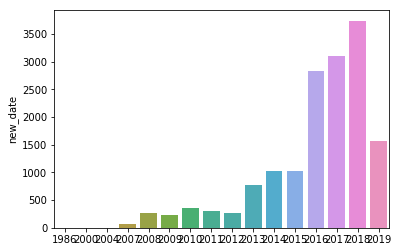

In [14]:
# claims per year
sns.barplot(x=data['new_date'].dt.year.value_counts().index, y=data['new_date'].dt.year.value_counts())

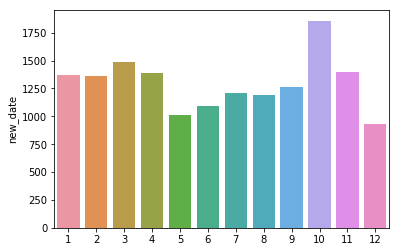

In [15]:
# Claims per month
sns.barplot(x=data['new_date'].dt.month.value_counts().index, y=data['new_date'].dt.month.value_counts())

In [16]:
# fake/real claims per month
month = data[data['new_date'].dt.year == 2018]
month.label.value_counts()

0    2115
1    1244
2     378
Name: label, dtype: int64

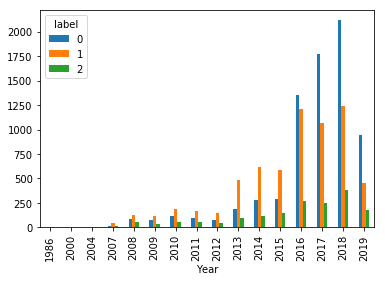

In [17]:
# Plot labels against each year
data['Year'] = data['new_date'].apply(lambda x: "%d" % (x.year))
year_label = data.groupby(['Year', 'label']).size().unstack(fill_value=0)
year_label.plot.bar()

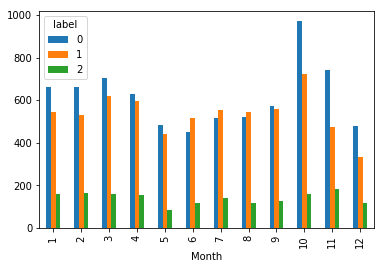

In [18]:
# Plot labels against each month
data['Month'] = data['new_date'].apply(lambda x: "%d" % (x.month))
month_label = data.groupby(['Month', 'label']).size().unstack(fill_value=0)
# For some reason, have to reorder the month index by adding a new column
month_order = [1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]
month_label['month'] = month_order
month_label = month_label.sort_values(by=['month'])
# Dropping the added column as it is not needed after reordering
month_label = month_label.drop(['month'], axis=1)
month_label.plot.bar()

In [19]:
# fake_data = data[data['label'] == 0]
# fake_data_month = fake_data[fake_data['new_date'].dt.month==10]
# fake_data_month.label.value_counts()

In [20]:
# # Created a month dataframe
# month_index = data['new_date'].dt.month.value_counts().index.tolist()
# month_count = data['new_date'].dt.month.value_counts().tolist()
# month_data = pd.DataFrame(columns=['Month', 'Count'])
# month_data['Month'] = month_index
# month_data['Count'] = month_count
# month_data

In [21]:
# # Group together all counts less than average in to Others
# value_mask = data.date.isin(date_count.index[date_count < 5]) 
# data.loc[value_mask,'date'] = "Other"
# # data.date.value_counts()

### Related Articles 

In [22]:
# related articles is of type object
data.dtypes

Unnamed: 0                   int64
claim                       object
claimant                    object
date                        object
id                           int64
label                        int64
related_articles            object
new_date            datetime64[ns]
Year                        object
Month                       object
dtype: object

In [23]:
data.columns.get_loc('related_articles')

6

In [24]:
# related articles are in str format
value = data.iloc[0][6]
type(value)

str

In [25]:
# function to convert strings to numpy array
def str2array(value):
    str_list = re.findall(r'\d+', value)
    int_list = list(map(int, str_list))
    article_array = np.array(int_list)
    return article_array

In [26]:
data['article_array'] = data['related_articles'].apply(str2array)

In [27]:
data.columns.get_loc('article_array')

10

In [28]:
value = data.iloc[0][7]
type(value)

pandas._libs.tslibs.timestamps.Timestamp

## Encoding

### Claimant Encode

In [29]:
# Label encoding
data['claimant']=data['claimant'].astype('category')
data['claimant_cat']=data['claimant'].cat.codes
claimant_labels = dict(enumerate(data['claimant'].cat.categories))

### Claim Encode

#### CountVectorizer 

In [30]:
# vectorizer = CountVectorizer(analyzer = "word", # the feature should be made of word
#                              tokenizer = None, 
#                              preprocessor = None, 
#                              stop_words = 'english', # Remove stop words such as “the”, “a”, etc.
#                              max_features = 500)
# claim_vec = vectorizer.fit_transform(data['claim'].values.astype('U'))

In [31]:
# claim_array = claim_vec.toarray()

#### TFID

In [32]:
tf_vectorizer = TfidfVectorizer(analyzer = "word",
                                stop_words='english', 
                                max_df=0.9, # if word appeared in 70% of data then remove it
                                max_features = 500)
tf_vec = tf_vectorizer.fit_transform(data['claim'].values.astype('U'))
# print(tf_vectorizer.get_feature_names())

In [33]:
tf_claim_array = tf_vec.toarray()

### Date Encode

Methods of encoding dates:
    - Label encoding
    - One hot encode month and year
    - consecutive date encoding (how many days since a specified day)

In [34]:
# # Label encoding
# data['date']=data['date'].astype('category')
# data['date_cat']=data['date'].cat.codes
# date_labels = dict(enumerate(data['date'].cat.categories))

In [35]:
# create new feature with consecutive days since January 1st, 1986
data['start_date'] = pd.to_datetime('1986-01-01', format='%Y-%m-%d')
data['cont_days'] = (data['new_date'] - data['start_date']).dt.days
data = data.drop(['start_date'], axis=1)

In [36]:
# Convert Year and Month features in to int (instead of str before)
data['Year'] = data['Year'].astype(int)
data['Month'] = data['Month'].astype(int)

### Cleaned Data Frame

In [37]:
data.head()

,Unnamed: 0,claim,claimant,date,id,label,related_articles,new_date,Year,Month,article_array,claimant_cat,cont_days
0,0,A line from George Orwell's novel 1984 predict...,Unknown,17/07/2017,0,0,"[122094, 122580, 130685, 134765]",2017-07-17,2017,7,"[122094, 122580, 130685, 134765]",289,11520
1,1,Maine legislature candidate Leslie Gibson insu...,Unknown,17/03/2018,1,2,"[106868, 127320, 128060]",2018-03-17,2018,3,"[106868, 127320, 128060]",289,11763
2,2,A 17-year-old girl named Alyssa Carson is bein...,Unknown,18/07/2018,4,1,"[132130, 132132, 149722]",2018-07-18,2018,7,"[132130, 132132, 149722]",289,11886
3,3,In 1988 author Roald Dahl penned an open lette...,Unknown,04/02/2019,5,2,"[123254, 123418, 127464]",2019-02-04,2019,2,"[123254, 123418, 127464]",289,12087
4,4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,22/03/2016,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]",2016-03-22,2016,3,"[41099, 89899, 72543, 82644, 95344, 88361]",102,11038


In [38]:
# dropping features that are not numerical
features = data.drop(['Unnamed: 0','claim','claimant','date','id','related_articles','new_date','article_array'], axis=1)
claim_features = pd.DataFrame(data=tf_claim_array, columns = tf_vectorizer.get_feature_names())
cleaned_features = pd.concat([features, claim_features], axis=1)

In [39]:
cleaned_features.head()

,label,Year,Month,claimant_cat,cont_days,000,10,100,11,12,...,won,word,work,workers,working,world,year,years,york,young
0,0,2017,7,289,11520,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,2,2018,3,289,11763,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,1,2018,7,289,11886,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.369537,0.0,0.0,0.0
3,2,2019,2,289,12087,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,2,2016,3,102,11038,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.589457,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [40]:
# Split test and train data
X = cleaned_features.drop(['label'], axis=1)
y = cleaned_features['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [41]:
model = LogisticRegression()
# model = MultinomialNB()
model.fit(X_train, y_train)

/home/aaron/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/aaron/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
predictions = model.predict(X_test)

In [43]:
score = accuracy_score(y_test, predictions)
print("accuracy:   %0.3f" % score)

accuracy:   0.587


In [44]:
model = MultinomialNB(alpha=0.1)
last_score = 0
for alpha in np.arange(0,1,.1):
    model_ = MultinomialNB(alpha=alpha)
    model_.fit(X_train, y_train)
    predictions = model_.predict(X_test)
    score = accuracy_score(y_test, predictions)
    if score > last_score:
        model = model_
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

Alpha: 0.00 Score: 0.45447
Alpha: 0.10 Score: 0.45297
Alpha: 0.20 Score: 0.45125
Alpha: 0.30 Score: 0.45104
Alpha: 0.40 Score: 0.45125


/home/aaron/.local/lib/python3.5/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.50 Score: 0.45040
Alpha: 0.60 Score: 0.44997
Alpha: 0.70 Score: 0.44975
Alpha: 0.80 Score: 0.44890
Alpha: 0.90 Score: 0.44804
